<a href="https://colab.research.google.com/github/covidba/covid/blob/master/covid19_itabuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evolução da COVID-19 em Itabuna/BA
**Fonte**: https://www.facebook.com/PrefeituradeItabuna/  
**Dados crus**: https://raw.githubusercontent.com/covidba/covid/master/itabuna.csv   
**Github**: https://github.com/covidba/covid

In [1]:
import sys
from google.colab import drive
drive.mount('/content/drive')

!cd drive
#!rm -r model
!git clone https://github.com/ramonfontes/Mathematical-and-Statistical-Modeling-of-COVID19-in-Brazil/ model
!pip install platypus-opt
!pip install pyswarms==1.1.0

#add the path were the models are
sys.path.append("model/main/")

from modelos import SIR

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Cloning into 'model'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 1363 (delta 1), reused 71 (delta 1), pack-reused 1292
Receiving objects: 100% (1363/1363), 84.36 MiB | 33.43 MiB/s, done.
Resolving deltas: 100% (572/572), done.
     |████████████████████████████████| 71kB 2.0MB/s 
     |████████████████████████████████| 102kB 2.6MB/s 


In [2]:
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import pandas as pd
import numpy as np

data_atual = date.today().strftime("%d-%m-%Y")
cidade = 'Itabuna'
cidade_file_name = 'itabuna'
populacao = 213223
url = 'https://raw.githubusercontent.com/covidba/covid/master/%s.csv' % cidade_file_name
df = pd.read_csv(url, usecols=['data', 'confirmados','recuperados', 'mortes']) #, parse_dates=['data'])
df.columns = ['data', 'Casos confirmados', 'Casos recuperados', 'Mortes']
df['data'] = pd.to_datetime(df['data'])


In [3]:
#Start the model with population size
model = SIR(tamanhoPop = populacao)
#create a series with the cummulative number of cases
y = df["Casos confirmados"]
#Give the number of days since the day of first case confirmed
x = range(1,len(df["Casos confirmados"]) + 1)
model.fit(x = x, y = y)
#Predict the number of cases
df["Expectativa"] = model.predict(x)

2020-06-16 20:04:29,640 - pyswarms.single.local_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 3, 'p': 1}
pyswarms.single.local_best:   0%|          |0/500model/main/modelos.py:156: RuntimeWarning: overflow encountered in exp
  h = 1.0/(1.0+ np.exp(-2.0*50*t))
pyswarms.single.local_best: 100%|██████████|500/500, best_cost=2.59
2020-06-16 20:06:56,380 - pyswarms.single.local_best - INFO - Optimization finished | best cost: 2.5905338144962284, best pos: [ 0.2605539   0.16354622  0.17063612 51.32509123]


In [28]:
#Projections about the future
futherCases = pd.DataFrame.from_dict({"data":pd.date_range(start = df['data'].max()+timedelta(days=1) , end = df['data'].max()+timedelta(days=7))})

df_proj = pd.concat([df,futherCases])
#create the new series to be predicted
predictions = model.predict(df_proj)

model/main/modelos.py:156: RuntimeWarning: overflow encountered in exp
  h = 1.0/(1.0+ np.exp(-2.0*50*t))


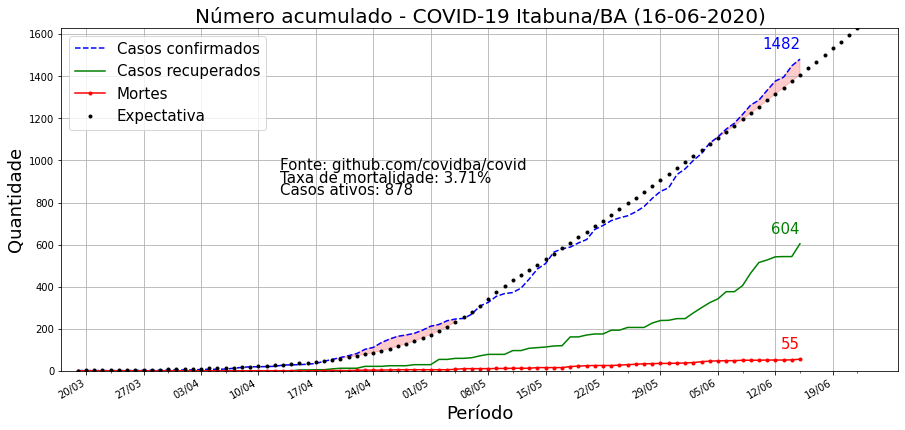

In [34]:
from matplotlib.dates import MO

new_df = df.append(futherCases)
new_df.reset_index(inplace=True, drop=True)
new_df['Expectativa'] = predictions

#set date as index
lista_data = new_df['data']
new_df.set_index('data', inplace=True)
new_df.tail(20)

fig, ax = plt.subplots(figsize=(15,7))
colors = ['b','g','r', 'black']
ls = ['--', '-', '.-', '.']
new_df.plot(ax=ax, color=colors, style=ls)
fig.autofmt_xdate()

#set ticks every week
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(MO))
#plt.gca().xaxis.set_major_formatter(plt.FixedFormatter(df.index.to_series().dt.strftime("%d/%m")))

ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=10)
ax.set_xticks(ax.get_xticks()[::1])
ax.legend(prop=dict(size=15))

# ADICIONAR VALORES
casos_confirmados_series = pd.DataFrame(new_df['Casos confirmados'])
ultimo_caso_valido_id = casos_confirmados_series.index.get_loc(casos_confirmados_series.last_valid_index())
def adicionar_valores(caso, color):
  ax.annotate(int(new_df[caso].max()), xy=(lista_data[ultimo_caso_valido_id], new_df[caso].max()), 
              xycoords='data', ha='right', fontsize=15, color=color,
              xytext=(0, 10), textcoords='offset points')
  
adicionar_valores('Casos confirmados', 'b')
adicionar_valores('Casos recuperados', 'g')
adicionar_valores('Mortes', 'r')

casos_ativos = int(new_df['Casos confirmados'].max() - new_df['Casos recuperados'].max())
taxa_mortalidade = (100 * new_df['Mortes'].max()) / new_df['Casos confirmados'].max()
url_expectativa = 'github.com/covidba/covid'
def plotar_info(texto, x, y):
  ax.annotate(texto , xy=(lista_data.min() + timedelta(days=10), new_df['Expectativa'].max()/2+y), 
            xycoords='data', ha='left', fontsize=15, color='black',
            xytext=(x, 0), textcoords='offset points')

plotar_info('Casos ativos: %s' % casos_ativos, 120, 20)
plotar_info('Taxa de mortalidade: %.2f%%' % taxa_mortalidade, 120, 80)
plotar_info('Fonte: %s' % url_expectativa, 120, 140)

ax.fill_between(new_df.index, new_df['Casos confirmados'], new_df['Expectativa'], 
                where=new_df['Casos confirmados']>=new_df['Expectativa'], alpha=0.2, color='red')

ax.set_ylim(0, new_df['Expectativa'].max())
ax.set_xlim([lista_data.min()-timedelta(days=2), lista_data.max() + timedelta(days=5)])
ax.set_title("Número acumulado - COVID-19 %s/BA (%s)" % (cidade, data_atual), fontsize=20)
ax.set_ylabel('Quantidade', fontsize=18)
ax.set_xlabel('Período', fontsize=18)
ax.grid(True)

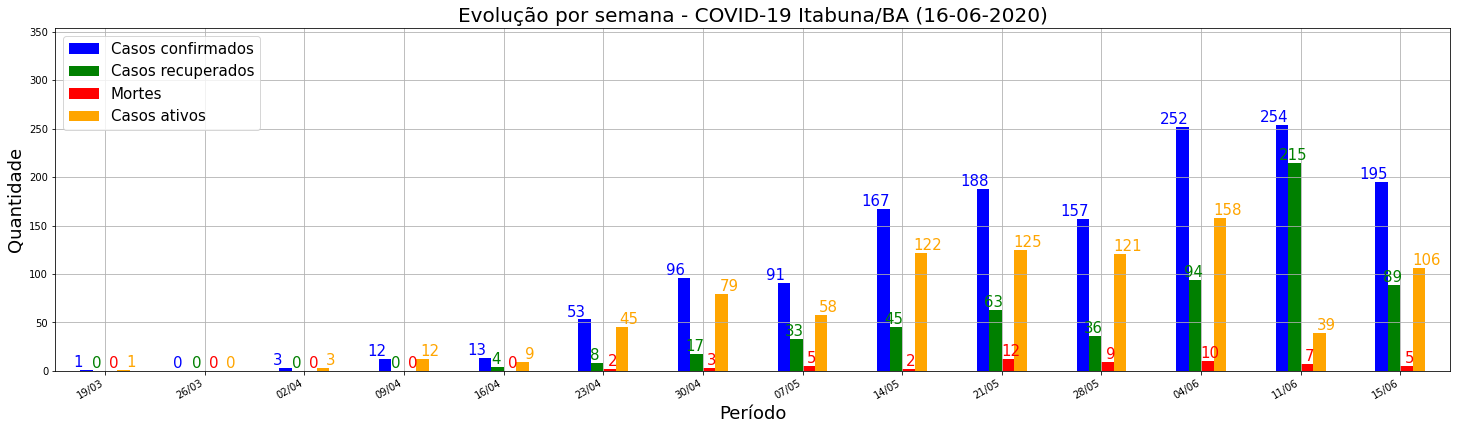

In [35]:
frequencia = 7
colors = ['b','g','r', 'orange']

dict_diaria = dict()
dict_diaria['data'] = []
dict_diaria['confirmados_diaria'] = []
dict_diaria['recuperados_diaria'] = []
dict_diaria['mortes_diaria'] = []
dict_diaria['ativos_diaria'] = []

casos_confirmados_diaria = []
casos_recuperados_diaria = []
casos_mortes_diaria = []
casos_ativos_diaria = []

for i, v in enumerate(new_df['Casos confirmados']):
  if not pd.isnull(v):
    casos_ativos_diaria.append(v - new_df['Casos recuperados'][i])

def alimentar_lista(lista, texto):
  for id, v in enumerate(new_df[texto]):
    if not pd.isnull(v):
      if(id) == 0:
        lista.append(v)  
      else:
        lista.append(v - new_df[texto][id-1])

alimentar_lista(casos_confirmados_diaria, 'Casos confirmados')
alimentar_lista(casos_recuperados_diaria, 'Casos recuperados')
alimentar_lista(casos_mortes_diaria, 'Mortes')

def alimentar_dict(lista, texto):
  soma_casos = 0
  for id, v in enumerate(lista):
    if not pd.isnull(v):
      if id % frequencia == 0:
        if texto == 'confirmados_diaria':
            dict_diaria['data'].append(lista_data[id])
        if id == 0:
          dict_diaria[texto].append(v)
        else:
          dict_diaria[texto].append(soma_casos)
          soma_casos = v
      else:
        soma_casos += v
        if(len(lista)-1 == id):
          dict_diaria[texto].append(soma_casos)
          if texto == 'confirmados_diaria':
            dict_diaria['data'].append(lista_data[id])

alimentar_dict(casos_confirmados_diaria, 'confirmados_diaria')
alimentar_dict(casos_recuperados_diaria, 'recuperados_diaria')
alimentar_dict(casos_mortes_diaria, 'mortes_diaria')
alimentar_dict(casos_ativos_diaria, 'ativos_diaria')

df_diaria = pd.DataFrame(dict_diaria)
df_diaria.columns = ['data', 'Casos confirmados', 'Casos recuperados', 'Mortes', 'Casos ativos']
novo_df = df_diaria

df_diaria['Casos ativos'] = df_diaria['Casos confirmados'] - df_diaria['Casos recuperados']


df_diaria.set_index('data', inplace=True)
fig, ax = plt.subplots(figsize=(25,7))
df_diaria.plot(ax=ax, color=colors, kind='bar')
fig.autofmt_xdate()

# workaround para erro em bar kind
plt.gca().xaxis.set_major_formatter(plt.FixedFormatter(df_diaria.index.to_series().dt.strftime("%d/%m")))

ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=10)
ax.set_xticks(ax.get_xticks()[::1])
ax.legend(prop=dict(size=15))

def plotar_valores(texto, cor, x):
  for i, v in enumerate(df_diaria[texto]):
    if not pd.isnull(v):
      ax.annotate(int(v), xy=(i, v), xycoords='data', ha='center', fontsize=15, color=cor,
                xytext=(x, 3), textcoords='offset points')

plotar_valores('Casos confirmados', 'b', -27)
plotar_valores('Casos recuperados', 'g', -8)
plotar_valores('Mortes', 'r', 9)
plotar_valores('Casos ativos', 'orange', 26)

def plotar_info(texto, x, y):
  ax.annotate(texto , xy=(new_df['Mortes'][4], new_df['Casos confirmados'][len(new_df['Casos confirmados'])-1]), 
              xycoords='data', ha='left', fontsize=15, color='black', 
              xytext=(x, new_df['Casos confirmados'][len(new_df['Casos confirmados'])-1]-y), textcoords='offset points')

plotar_info('Casos ativos: %s' % casos_ativos, 40, 40)
plotar_info('Taxa de mortalidade: %.2f%%' % taxa_mortalidade, 40, 60)
plotar_info('Fonte: %s' % url_expectativa, 40, 80)

ax.set_ylim([0, df_diaria['Casos confirmados'].max() + 100])
ax.set_title("Evolução por semana - COVID-19 %s/BA (%s)" % (cidade, data_atual), fontsize=20)
ax.set_ylabel('Quantidade', fontsize=18)
ax.set_xlabel('Período', fontsize=18)
ax.grid(True)

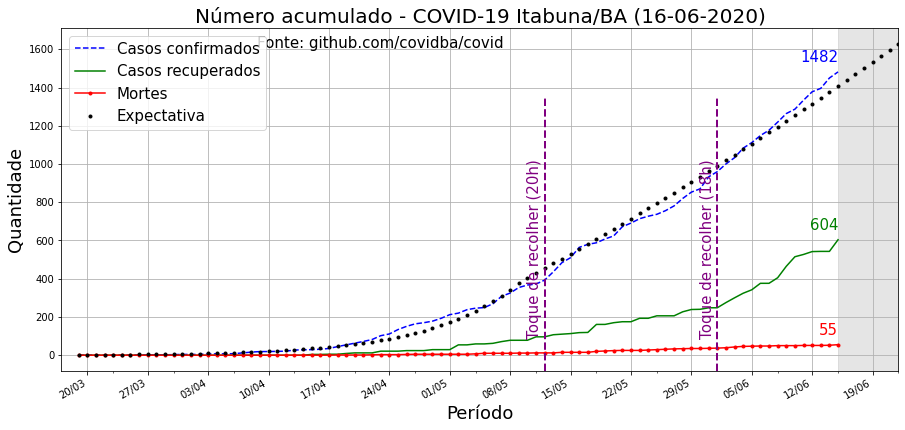

In [36]:
df1 = pd.read_csv(url, usecols=['data', 'restricao']) #, parse_dates=['data'])
df1['data'] = pd.to_datetime(df1['data'])
df1.columns = ['data', 'Medida Restritiva']

df1 = df1.append(futherCases)
df1.reset_index(inplace=True, drop=True)
df1['Expectativa'] = predictions

fig, ax = plt.subplots(figsize=(15,7))
colors = ['b','g','r', 'black']
ls = ['--', '-', '.-', '.']
new_df.plot(ax=ax, color=colors, style=ls)
fig.autofmt_xdate()

#set ticks every week
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(MO))

ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=10)
ax.set_xticks(ax.get_xticks()[::1])
ax.legend(prop=dict(size=15))

# pintar área de projeção
ax.axvspan(df1['data'][ultimo_caso_valido_id].strftime("%Y-%m-%d"), df1['data'][len(lista_data)-1].strftime("%Y-%m-%d"), 
           alpha=0.2, color='gray')

def adicionar_medida(texto, id, color='green'):
  ax.axvline(linewidth=2, color=color, ls='--', x=lista_data[(lista_data == pd.Timestamp(df1['data'][id])).argmax()], ymax=0.8)
  ax.annotate('%s' % texto, xy=(lista_data[(lista_data == pd.Timestamp(df1['data'][id])).argmax()], 100), rotation=90,
            xycoords='data', ha='center', fontsize=15, color=color,
            xytext=(-10, 0), textcoords='offset points')

# ADICIONAR MEDIDAS
def adicionar_medidas():
  for id, medida in enumerate(df1['Medida Restritiva']):
    # toque de recolher
    if not pd.isnull(medida):
      if medida == 0:
        adicionar_medida('Comércio aberto', id) 
      elif medida == 1:
        adicionar_medida('Comércio fechado', id, color='purple') 
      elif medida > 1:
        if medida == 24:
          adicionar_medida('Saída do toque de recolher', id)
        else:
          adicionar_medida('Toque de recolher (%sh)' % int(medida), id, color='purple')      
      elif medida == -1:
        adicionar_medida('Entrada no lockdown', id, color='purple')
      elif str(medida) == '-0':
        adicionar_medida('Saída do lockdown', id)
  
adicionar_medidas()

# ADICIONAR VALORES  
adicionar_valores('Casos confirmados', 'b')
adicionar_valores('Casos recuperados', 'g')
adicionar_valores('Mortes', 'r')

ax.annotate('Fonte: %s' % url_expectativa , xy=(df1['data'].min()+timedelta(days=35), new_df['Expectativa'].max()-20), 
            xycoords='data', ha='center', fontsize=15, color='black', xytext=(0, 0), textcoords='offset points')

ax.set_xlim([lista_data.min()-timedelta(days=2), lista_data.max()])
ax.set_title("Número acumulado - COVID-19 %s/BA (%s)" % (cidade, data_atual), fontsize=20)
ax.set_ylabel('Quantidade', fontsize=18)
ax.set_xlabel('Período', fontsize=18)
ax.grid(True)

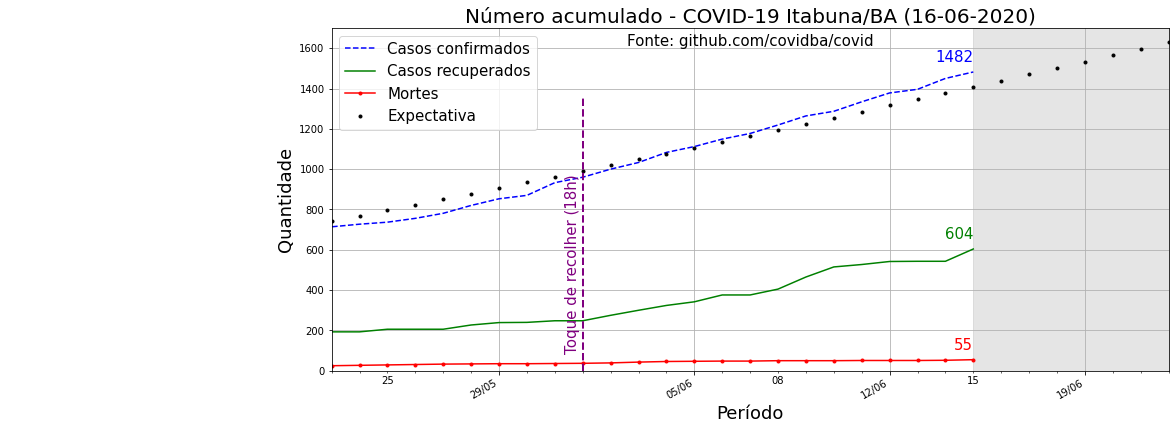

In [37]:
fig, ax = plt.subplots(figsize=(15,7))
colors = ['b','g','r', 'black']
ls = ['--', '-', '.-', '.']
new_df.plot(ax=ax, color=colors, style=ls)
fig.autofmt_xdate()

#set ticks every week
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(MO))

ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=10)
ax.set_xticks(ax.get_xticks()[::1])
ax.legend(prop=dict(size=15))

# pintar área de projeção
ax.axvspan(df1['data'][ultimo_caso_valido_id].strftime("%Y-%m-%d"), df1['data'][len(lista_data)-1].strftime("%Y-%m-%d"), 
           alpha=0.2, color='gray')
adicionar_medidas()

# ADICIONAR VALORES
adicionar_valores('Casos confirmados', 'b')
adicionar_valores('Casos recuperados', 'g')
adicionar_valores('Mortes', 'r')

ax.annotate('Fonte: %s' % url_expectativa , xy=(df1['data'].max()-timedelta(days=15), new_df['Expectativa'].max()-20), 
            xycoords='data', ha='center', fontsize=15, color='black', xytext=(0, 0), textcoords='offset points')

ax.set_ylim([0, new_df['Expectativa'].max() + 70])
ax.set_xlim([lista_data.max() - timedelta(days=30), lista_data.max()])
ax.set_title("Número acumulado - COVID-19 %s/BA (%s)" % (cidade, data_atual), fontsize=20)
ax.set_ylabel('Quantidade', fontsize=18)
ax.set_xlabel('Período', fontsize=18)
ax.grid(True)